# Import Library

In [1]:
# Install PyTorch 2.1.0 with CUDA 11.8
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# Install Ultralytics
!pip install ultralytics

# Install Albumentation (for Data Augmentation)
!pip install -q albumentations

# Install pycocotools
!pip install pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Core
import os
import time
import json
import torch
import cv2
import numpy as np

# Torchvision (detection models + utilities)
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
from torchvision.datasets import CocoDetection
from torchvision import transforms

# Torch utilities
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

# Data handling / augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Progress bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Data Preparation

In [3]:
# Set dataset root path
coco_root = r"C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Human Detection Project\cocodatasets"
images_dir = os.path.join(coco_root, "val2017")
annotations_path = os.path.join(coco_root, "annotations", "instances_val2017.json")

In [4]:
# Basic transform (expand later in preprocessing)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load full COCO val2017 dataset with all categories
coco_dataset = CocoDetection(root=images_dir, annFile=annotations_path, transform=transform)

print("Total images in val2017:", len(coco_dataset))

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
Total images in val2017: 5000


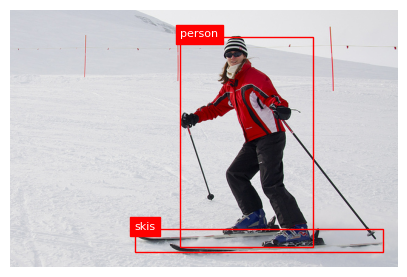

In [5]:
# Show a sample image with annotations

def show_sample(dataset, idx=0):
    image, targets = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    ax = plt.gca()

    for target in targets:
        bbox = target['bbox']
        category_id = target['category_id']
        label = coco_dataset.coco.loadCats(category_id)[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1], label, color='white', backgroundcolor='red', fontsize=8)
    
    plt.axis('off')
    plt.show()

# Test the function
show_sample(coco_dataset, idx=5)

# Preprocessing

In [8]:
from glob import glob

# Path to images
image_dir = images_dir  # already defined earlier

# Load all image paths in the directory
all_image_paths = glob(os.path.join(image_dir, '*.jpg'))

# Verify sample paths
print("Example full image paths:")
for path in all_image_paths[:3]:
    print(path)

Example full image paths:
C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Human Detection Project\cocodatasets\val2017\000000000139.jpg
C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Human Detection Project\cocodatasets\val2017\000000000285.jpg
C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Human Detection Project\cocodatasets\val2017\000000000632.jpg


In [9]:
# Define training transform
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(scale=(1 - 0.1, 1 + 0.1), translate_percent=(0.05, 0.05), rotate=(-10, 10), p=0.3),
    A.CLAHE(p=0.2),
    A.MotionBlur(p=0.1),
    A.HueSaturationValue(p=0.2),
    A.Resize(640, 640),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [10]:
class CocoDatasetWithAlbumentations(Dataset):
    def __init__(self, coco, transforms=None):
        self.coco = coco
        self.transforms = transforms

        # Map COCO category_id to contiguous class index
        self.cat_ids = sorted(self.coco.coco.getCatIds())
        self.cat_id_to_index = {cat_id: i+1 for i, cat_id in enumerate(self.cat_ids)}  # +1 because 0 = background

    def __len__(self):
        return len(self.coco)

    def __getitem__(self, idx):
        try:
            image, targets = self.coco[idx]
            image = image.mul(255).byte().permute(1, 2, 0).numpy()

            bboxes = [obj["bbox"] for obj in targets]
            category_ids = [obj["category_id"] for obj in targets]

            if len(bboxes) == 0:
                return self.__getitem__((idx + 1) % len(self))

            if self.transforms:
                transformed = self.transforms(image=image, bboxes=bboxes, category_ids=category_ids)
                image = transformed["image"].float() / 255.0
                bboxes = transformed["bboxes"]
                category_ids = transformed["category_ids"]

            valid_boxes = []
            valid_labels = []
            for box, label in zip(bboxes, category_ids):
                x, y, w, h = box
                if w > 0 and h > 0:
                    x_min = x
                    y_min = y
                    x_max = x + w
                    y_max = y + h
                    if x_max > x_min and y_max > y_min:
                        valid_boxes.append([x_min, y_min, x_max, y_max])
                        # 🔁 Convert COCO cat_id to class index
                        class_index = self.cat_id_to_index.get(label, None)
                        if class_index is not None:
                            valid_labels.append(class_index)

            if len(valid_boxes) == 0:
                return self.__getitem__((idx + 1) % len(self))

            target = {
                "boxes": torch.tensor(valid_boxes, dtype=torch.float32),
                "labels": torch.tensor(valid_labels, dtype=torch.int64)
            }

            return image, target

        except Exception as e:
            print(f"⚠️ Skipping sample {idx} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self))

In [11]:
# Apply albumentations transform to your COCO dataset
train_dataset = CocoDatasetWithAlbumentations(coco_dataset, transforms=train_transform)

# Optional: check one sample
img, target = train_dataset[0]
print("Image shape:", img.shape)
print("Target keys:", target.keys())

Image shape: torch.Size([3, 640, 640])
Target keys: dict_keys(['boxes', 'labels'])


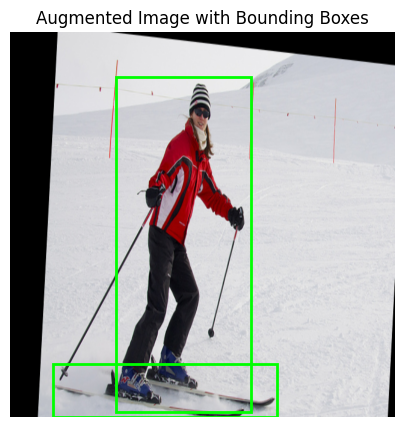

In [12]:
def show_augmented_sample(dataset, idx=0):
    img, target = dataset[idx]
    img = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    for bbox in target["boxes"]:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
    ax.set_title("Augmented Image with Bounding Boxes")
    plt.axis('off')
    plt.show()

# Example usage
show_augmented_sample(train_dataset, idx=5)

# Architecture

### Faster RCNN

In [13]:
def get_faster_rcnn_model(num_classes=80, pretrained=True, device=None):
    """
    Load Faster R-CNN model from Torchvision.

    Parameters:
    - num_classes: int, number of classes INCLUDING background
    - pretrained: bool, whether to use pretrained weights
    - device: str, 'cuda' or 'cpu'; if None, auto-detect

    Returns:
    - model: Faster R-CNN model on the specified device
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT if pretrained else None
    model = fasterrcnn_resnet50_fpn(weights=weights)

    # Replace head with custom classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    print(f"Loaded Faster R-CNN for {num_classes} classes (including background).")
    return model.to(device)

# Modeling


### Faster RCNN

In [14]:
def train_faster_rcnn(model, dataset, device='cuda', num_epochs=10, batch_size=4, learning_rate=0.005, save_path=None):
    """
    Train a Faster R-CNN model on the given dataset using AMP (Automatic Mixed Precision).

    Parameters:
    - model: the Faster R-CNN model
    - dataset: your custom dataset
    - device: 'cuda' or 'cpu'
    - num_epochs: number of training epochs
    - batch_size: mini-batch size
    - learning_rate: learning rate for optimizer
    - save_path: optional path to save trained model
    """

    # Prepare DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    # Move model to device
    model = model.to(device)

    # Define optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

    # Initialize AMP scaler
    scaler = GradScaler()

    print(f"Starting training for {num_epochs} epochs on {device.upper()}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for images, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            # Forward pass with AMP
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass with AMP
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += losses.item()

        avg_loss = running_loss / len(dataloader)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} - Time={elapsed:.2f}s")

        # Optional: Save model after each epoch
        if save_path:
            torch.save(model.state_dict(), f"{save_path}_epoch{epoch+1}.pth")

    print("Training complete.")
    return model

In [15]:
# num_classes = 80 (actual classes) + 1 (background)
num_classes = len(train_dataset.cat_id_to_index) + 1  

# Create Faster R-CNN model with correct number of classes
frcnn_model = get_faster_rcnn_model(
    num_classes=num_classes,
    pretrained=True,
    device='cuda'
)

Loaded Faster R-CNN for 81 classes (including background).


In [16]:
# If you want to resume training (change X to the number of your last epoch)
# model.load_state_dict(torch.load("frcnn_model_epochX.pth"))

In [17]:
# Train Faster R-CNN model
trained_frcnn = train_faster_rcnn(
    model=frcnn_model,
    dataset=train_dataset,    # From your Preprocessing section
    device='cuda',            # Or 'cpu' if needed
    num_epochs=5,             # Adjust based on resources
    batch_size=4,             # Adjust based on your GPU VRAM
    learning_rate=0.005,      # Recommended for Faster R-CNN
    save_path='frcnn_model'   # Will save frcnn_model_epoch1.pth, etc.
)

# Save final model after all epochs
torch.save(trained_frcnn.state_dict(), "frcnn_model_final.pth")

Starting training for 5 epochs on CUDA


Epoch 1/5:   0%|          | 5/1250 [00:05<21:47,  1.05s/it]


KeyboardInterrupt: 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_path = r"C:\Users\ChrisBear\Python 3 General Notebook\Indonesia AI\Human Detection Project\frcnn_model_final.pth"

frcnn_model.load_state_dict(torch.load(save_path, map_location=device))
frcnn_model.to(device)   # move model to correct device

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Evaluation

### Faster RCNN

In [19]:
def load_frcnn_model(model_path, num_classes, device='cuda'):
    model = fasterrcnn_resnet50_fpn(weights=None)  # Don't use pretrained weights now
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device).eval()
    return model

# Load trained model
num_classes = len(train_dataset.cat_id_to_index) + 1  # Same logic as in training
frcnn_model = load_frcnn_model("frcnn_model_final.pth", num_classes, device='cuda')

In [20]:
def run_frcnn_inference(model, dataset, device='cuda', conf_threshold=0.5, iou_threshold=0.5):
    results = []

    for idx in tqdm(range(len(dataset)), desc="Evaluating Faster R-CNN"):
        img, target = dataset[idx]
        img_tensor = img.to(device).unsqueeze(0)

        with torch.no_grad():
            output = model(img_tensor)[0]

        boxes = output['boxes'].cpu()
        scores = output['scores'].cpu()
        labels = output['labels'].cpu()

        # Filter only human detections (COCO person class id = 1)
        selected = (labels == 1) & (scores >= conf_threshold)
        boxes = boxes[selected]
        scores = scores[selected]

        if boxes.shape[0] > 0:
            keep = nms(boxes, scores, iou_threshold)
            boxes = boxes[keep]
            scores = scores[keep]

        results.append({
            'image_id': idx,
            'pred_boxes': boxes.numpy(),
            'pred_scores': scores.numpy(),
            'gt_boxes': target['boxes'][target['labels'] == 1].cpu().numpy()
        })

    return results

In [21]:
def compute_iou(box1, box2):
    """Computes IoU between two bounding boxes (x1, y1, x2, y2 format)."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

In [22]:
def evaluate_frcnn_predictions(results, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    TP, FP, FN = 0, 0, 0
    all_precisions, all_recalls, all_aps = [], [], []

    for iou_thresh in iou_thresholds:
        total_tp, total_fp, total_fn = 0, 0, 0
        for res in results:
            gt = res['gt_boxes']
            pred = res['pred_boxes']
            matched = np.zeros(len(gt))

            for pred_box in pred:
                found_match = False
                for i, gt_box in enumerate(gt):
                    iou = compute_iou(pred_box, gt_box)
                    if iou >= iou_thresh and not matched[i]:
                        matched[i] = 1
                        found_match = True
                        break
                if found_match:
                    total_tp += 1
                else:
                    total_fp += 1

            total_fn += (len(gt) - matched.sum())

        precision = total_tp / (total_tp + total_fp + 1e-6)
        recall = total_tp / (total_tp + total_fn + 1e-6)
        ap = precision * recall  # simplified approximation

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_aps.append(ap)

        if iou_thresh == 0.5:
            TP, FP, FN = total_tp, total_fp, total_fn

    mAP_50 = all_aps[0]
    mAP_5095 = np.mean(all_aps)

    confusion = {
        'TP': TP,
        'FP': FP,
        'FN': FN
    }

    return {
        'Precision@0.5': all_precisions[0],
        'Recall@0.5': all_recalls[0],
        'mAP@0.5': mAP_50,
        'mAP@0.5:0.95': mAP_5095,
        'ConfusionMatrix': confusion
    }

In [23]:
# Subset of dataset (e.g., first 200 images) for faster testing
subset = torch.utils.data.Subset(train_dataset, list(range(200)))

# Measure inference time + get predictions
start_time = time.time()
frcnn_results = run_frcnn_inference(frcnn_model, subset, device='cuda')
end_time = time.time()

# Evaluate metrics
frcnn_metrics = evaluate_frcnn_predictions(frcnn_results)
avg_inference_time = (end_time - start_time) / len(subset)

# Show results
print("\nEvaluation Results for Faster R-CNN (Human only):")
for key, val in frcnn_metrics.items():
    print(f"{key}: {val:.4f}" if isinstance(val, float) else f"{key}: {val}")
print(f"Avg Inference Time per Image: {avg_inference_time:.4f} sec")

Evaluating Faster R-CNN: 100%|██████████| 200/200 [00:19<00:00, 10.38it/s]



Evaluation Results for Faster R-CNN (Human only):
Precision@0.5: 0.5393
Recall@0.5: 0.7607
mAP@0.5: 0.4103
mAP@0.5:0.95: 0.2074
ConfusionMatrix: {'TP': 391, 'FP': 334, 'FN': 123.0}
Avg Inference Time per Image: 0.0964 sec
